# Proyecto final

**Maestría en Métodos para el Análisis de Políticas Públicas**

Docente: Dra. Daniela Alejandra Moctezuma Ochoa 

Alumno: `Erick Gabriel Fajardo Martínez`

## Problema de investigación

El Tren Maya es un proyecto de infraestructura en desarrollo en México que tiene como objetivo construir una red de trenes de alta velocidad en la región de Yucatán. La idea es que el tren permita a los visitantes acceder a las principales atracciones turísticas de la región, así como mejorar la conectividad entre las diferentes ciudades y pueblos del área. Sin embargo, ha habido cierto controversia en torno al proyecto, ya que algunos temen que pueda afectar a las comunidades locales y al medio ambiente.

El impacto al medio ambiente es una de las preocupaciones más grandes, dado que el área geográfica donde está siendo construído cuenta con una gran densidad y versidad de flora y fauna. La construcción de este proyecto se ha llevado a cabo por etapas, donde cada una corresponde a un tramo de la ruta que recorrerá el tren. 

Actualmente, el tramo 5 que unirá a la ciudad de Cancún con Playa del Carmen es el que está en construcción, el cual ha sido un foco de crítica por la inmensa tala de árboles que ocasionó. 

## Objetivo

El presente trabajo pretende hacer un análisis exploratorio del estado de la vegetación de una sección del tramo 5 mediante el uso de imágenes satelitales.


## Método
1. Definición del área de interés 

2. Descarga de imágenes
    - Se obtuvieron imágenes del satélite Sentinel-2 para el período Marzo 2021 (Inicio de construcción del tramo 5) - Diciembre 2022

3. Preprocesamiento de imágenes
    - Construcción de un conjunto de datos con la información de las imágenes
    - Eliminación de pixeles que pertenecen a nubes, sombras de nubes y cuerpos de agua

4. Visualización de imágenes procesadas

5. Análisis del Índice Normalizado de Diferencias de Vegetación 


In [129]:
# Librerias

# Manipulacion 
import pandas as pd 
import numpy as np
import geopandas as gpd
import re
from datetime import datetime

# Earth engine (descarga de imagenes)
import ee 
import eemont
import geemap

# Plot
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.colors
from IPython.display import Image

In [ ]:
# Autentificar Earth engine
# ee.Authenticate() # Esto solo debe ser ejecutado la primera vez y cada vez que el token expira

ee.Initialize()

## 1. Definir área de estudio

In [56]:
# Coordenadas

# Sección del tramo 5
lat = 20.842169507535644
lon = -86.95743506097378

# Punto de interés
poi = ee.Geometry.Point(lon, lat)

# Periodo de tiempo
start_date = "2021-03-01"
end_date = "2022-12-07"

In [57]:
# Agregar banda de Indice de Vegetacion Normalizado
def addNDVI(image):
  ndvi = image.normalizedDifference(['B8', 'B4']).rename('ndvi')
  return image.addBands(ndvi)

## 2. Descarga de imágenes

In [58]:
# Función para descargar imágenes

def get_s2_sr_cld_col(aoi, start_date, end_date):
    # Imágenes de Sentinel 2
    s2_sr_col = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterBounds(aoi)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', 60))
        .map(addNDVI))

    # Imágenes para identificar nubes
    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(aoi)
        .filterDate(start_date, end_date))

    # Se unen ambas colecciones
    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))

In [72]:
# Funcion para visualizar imágenes
def display_img(ids, parameters, ndvi_display = False, cloud_filter = False):

    image_list = sentinel_list

    if cloud_filter == True:
        image_list = sentinel_mask_list

    for i in ids:
    
        # Fecha de captura
        date = datetime.strptime(re.findall("(?<=\_)\\d+(?=T)", ee.Image(image_list.get(i)).get("DATATAKE_IDENTIFIER").getInfo())[0], "%Y%m%d").date()

        # Nubosidad
        cloud = ee.Image(image_list.get(i)).get("CLOUDY_PIXEL_PERCENTAGE").getInfo()

        # Porcentaje de vegetación
        veg = ee.Image(image_list.get(i)).get("VEGETATION_PERCENTAGE").getInfo()

        # Porcentaje de agua
        water = ee.Image(image_list.get(i)).get("WATER_PERCENTAGE").getInfo()

        # Informacion de la imagen
        print("Imagen #", i, date, "Nubosidad:", cloud,"Porcentaje de vegetación:", veg, "Porcentaje de agua:", water)

        if ndvi_display == True:
            display(Image(url = ee.Image(image_list.get(i)).normalizedDifference(["B8", "B4"]).getThumbURL(parameters)))

        else:
            # Plot
            display(Image(url = ee.Image(image_list.get(i)).getThumbURL(parameters)))
        
# Funcion para crear data frame con info de las imágenes
def img_info(ids):
    data = []
    for i in ids:

        # Fecha de captura
        date = datetime.strptime(re.findall("(?<=\_)\\d+(?=T)", ee.Image(image_list.get(i)).get("DATATAKE_IDENTIFIER").getInfo())[0], "%Y%m%d").date()

        # Nubosidad
        cloud = ee.Image(image_list.get(i)).get("CLOUDY_PIXEL_PERCENTAGE").getInfo()

        # Porcentaje de vegetación
        veg = ee.Image(image_list.get(i)).get("VEGETATION_PERCENTAGE").getInfo()
        
        # Porcentaje de pixeles clasificados como no vegetacion
        no_veg = ee.Image(image_list.get(i)).get("NOT_VEGETATED_PERCENTAGE").getInfo()
        
        # Porcentaje de agua
        water = ee.Image(image_list.get(i)).get("WATER_PERCENTAGE").getInfo()

        # Informacion de la imagen
        print("Imagen #", i, date, "Nubosidad:", cloud,"Porcentaje de vegetación:", veg, "Porcentaje de agua:", water)
        
        image_data = [i, date, cloud, veg, no_veg, water]
        data.append(image_data)
    
    return data

In [65]:
# Descarga de imágenes
sentinel = get_s2_sr_cld_col(poi, start_date = start_date, end_date = end_date)
print("Se obtuvieron", sentinel.size().getInfo(), "imágenes para el periodo", start_date, "-", end_date)

sentinel_list = sentinel.toList(sentinel.size())

Se obtuvieron 204 imágenes para el periodo 2021-03-01 - 2022-12-07


In [139]:
# Parámetros de visualización
parameters = {
    "min":0, # 0 bueno
    "max":3000, # 3000 bueno
    "dimensions":800, # Tamaño cuadrado en pixeles
    "bands": ["B4", "B3", "B2"] # (R, G, B)
}

# Visualización de la primera y última imagen
display_img([3, 199], parameters = parameters)

Imagen # 3 2021-03-07 Nubosidad: 11.510718 Porcentaje de vegetación: 6.867416 Porcentaje de agua: 79.650259


Imagen # 199 2022-11-12 Nubosidad: 5.587879 Porcentaje de vegetación: 7.288255 Porcentaje de agua: 85.560125


In [138]:
# Nuevos parametros para región de interés
parameters_roi = {
    "min":0,
    "max":3000,
    "dimensions":800, # Tamaño cuadrado en pixeles
    "bands": ["B4", "B3", "B2"], # (R, G, B)
    "region": poi.buffer(10000) # Región de interes 10 km alrededor del punto de interés
}

# Se muestran las imagenes
display_img([3, 199], parameters_roi)

Imagen # 3 2021-03-07 Nubosidad: 11.510718 Porcentaje de vegetación: 6.867416 Porcentaje de agua: 79.650259


Imagen # 199 2022-11-12 Nubosidad: 5.587879 Porcentaje de vegetación: 7.288255 Porcentaje de agua: 85.560125


In [ ]:
# DF de informacion
tramo5_raw = pd.DataFrame(img_info(range(sentinel.size().getInfo())), columns = ["img_id", "date", "cloud_cover", "vegetation_percentage", "no_vegetation_percentage", "water_percentage"])

In [ ]:
# Escritura
# tramo5_raw.to_csv("../data/1_raw/tramo5_raw")

In [85]:
tramo5 = pd.read_csv("../data/1_raw/tramo5_raw")

# Se convierte a fecha la columna date
tramo5["date"] = pd.to_datetime(tramo5["date"])

tramo5.head()


,Unnamed: 0,img_id,date,cloud_cover,vegetation_percentage,no_vegetation_percentage,water_percentage
0,0,0,2021-03-02,13.937848,57.224184,2.299605,18.524384
1,1,1,2021-03-02,4.518698,7.066406,0.824506,86.467159
2,2,2,2021-03-07,15.241702,55.378145,2.338764,18.444499
3,3,3,2021-03-07,11.510718,6.867416,0.748017,79.650259
4,4,4,2021-03-12,32.566695,40.504023,2.299484,15.696260


Text(0.5, 1.0, 'Porcentaje de vegetación en la muestra de imágenes')

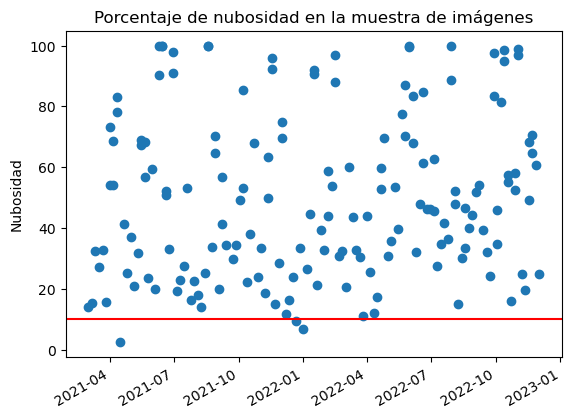

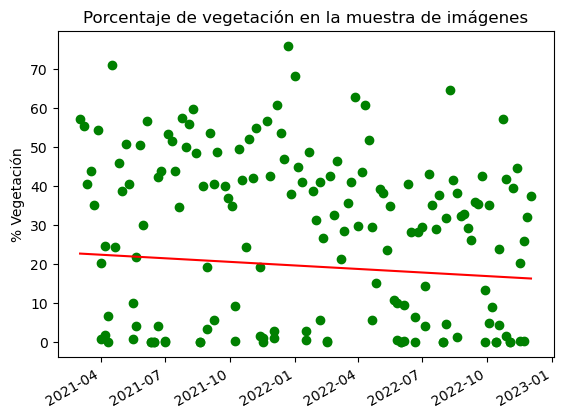

In [99]:
# Análisis exploratorio de datos

# Gráfico de nubosidad
fig, ax = plt.subplots()
ax.plot_date(tramo5.date[tramo5.water_percentage < 50], tramo5.cloud_cover[tramo5.water_percentage < 50])
fig.autofmt_xdate()
ax.axhline(y = 10, color = "r")
ax.set_ylabel("Nubosidad")
ax.set_title("Porcentaje de nubosidad en la muestra de imágenes")

# Gráfico de vegetación
fig, ax = plt.subplots()
ax.plot_date(tramo5.date[tramo5.water_percentage < 50], tramo5.vegetation_percentage[tramo5.water_percentage < 50], color = "g")
fig.autofmt_xdate()
x = np.array(dates.date2num(tramo5.date))
y = np.array(tramo5.vegetation_percentage)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)

plt.plot(x, p(x), color = "r")

ax.set_ylabel("% Vegetación")
ax.set_title("Porcentaje de vegetación en la muestra de imágenes")


## 3. Preprocesamiento de imágenes

    - Se eliminan nubes, sombras y cuerpos de agua. 

In [67]:
# Parámetros para preprocesamiento

CLD_PRB_THRESH = 50 # Umbral de probabilidad de que el pixel sea una nube
NIR_DRK_THRESH = 0.15 # Umbral para categorizar sombras
CLD_PRJ_DIST = 1 # Distancia a la que se proyectan las sombras de las nubes
BUFFER = 50 
AOI = poi

In [68]:
def add_cloud_bands(img):
    # Banda de probabilidad de que el pixel sea una nube
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    # Umbral para determinar si el pixel es una nube
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    # Se agrega la banda de probabilidad
    return img.addBands(ee.Image([cld_prb, is_cloud]))


In [69]:
def add_shadow_bands(img):
    # Pixeles catalogados como agua
    water = img.select('SCL').eq(6).rename("water")

    # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(water).rename('dark_pixels')

    # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))

    # Identify the intersection of dark pixels with cloud shadow projection.
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    # Add dark pixels, cloud projection, and identified shadows as image bands.
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows, water]))

In [70]:
def add_cld_shdw_mask(img):
    # Se agregn bandas de nubes
    img_cloud = add_cloud_bands(img)

    # Se agregan bandas de sombras
    img_cloud_shadow = add_shadow_bands(img_cloud)

    # Se combinan las bandas de nubes, sombras y agua. Toman el valor de 1 si son alguna de esas categorias
    is_cld_shdw_water = img_cloud_shadow.select("clouds").add(img_cloud_shadow.select("shadows")).add(img_cloud_shadow.select("water")).gt(0)

    # Corrección de las sombras pequeñas
    is_cld_shdw = (is_cld_shdw_water.focalMin(2).focalMax(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))

    # Se agrega la banda 
    return img.addBands(is_cld_shdw)


In [71]:
def apply_cld_shdw_mask(img):
    # Sombras, nubes y agua toman el valor de 0 si son alguna de esas categorías
    not_cld_shdw = img.select('cloudmask').Not()

    # Se actualizan las bandas con el mask
    return img.select('B.*', "ndvi").updateMask(not_cld_shdw)

In [73]:
# Se aplica el mask
sentinel_mask = (sentinel.map(add_cld_shdw_mask)
                         .map(apply_cld_shdw_mask))

sentinel_mask_list = sentinel_mask.toList(sentinel.size())

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60', 'ndvi']
204


## Visualización de imágenes procesadas

In [140]:
# Se muestran las mismas imágenes pero procesadas
display_img([3, 199], parameters_roi, cloud_filter = True)

Imagen # 3 2021-03-07 Nubosidad: 11.510718 Porcentaje de vegetación: 6.867416 Porcentaje de agua: 79.650259


Imagen # 199 2022-11-12 Nubosidad: 5.587879 Porcentaje de vegetación: 7.288255 Porcentaje de agua: 85.560125


## Análisis NDVI

$NDVI = \frac{NIR - RED}{NIR + RED}$

* Saludable = Valores altos (Color verde)
* No saludable = Valores bajos (Color rojo)

`ndvi = image.normalizedDifference(["B8", "B4"])`

In [100]:
# Parametros para el analisis NDVI
palette = ["red", "yellow", "green"]

ndvi_parameters = {
    "min":0, # Este color sera rojo - no saludable
    "max":0.4, # Lo que sea mayor sera verde - saludable
    "dimensions":800,
    "palette":palette,
    "region":roi
}

In [141]:
# NDVI index por imagen
display_img([3, 199], ndvi_parameters, ndvi_display = True, cloud_filter = True)

Imagen # 3 2021-03-07 Nubosidad: 11.510718 Porcentaje de vegetación: 6.867416 Porcentaje de agua: 79.650259


Imagen # 199 2022-11-12 Nubosidad: 5.587879 Porcentaje de vegetación: 7.288255 Porcentaje de agua: 85.560125


In [118]:
# Se crea el conjunto de datos con información del índice
Map = geemap.Map()

fc = ee.FeatureCollection(poi.buffer(10000))

tramo5_ndvi = sentinel.getTimeSeriesByRegion(reducer = [ee.Reducer.mean()],
geometry = fc,
bands = ["ndvi"],
scale = 10)

# Se convierte a Data Frame
tramo5_ndvi_raw = geemap.ee_to_pandas(tramo5_ndvi)
tramo5_ndvi_raw

,reducer,date,ndvi
0,mean,2021-03-02T16:27:40,0.595193
1,mean,2021-03-02T16:27:37,0.516662
2,mean,2021-03-07T16:27:39,0.686515
3,mean,2021-03-07T16:27:36,0.577148
4,mean,2021-03-12T16:27:40,0.387856
...,...,...,...
199,mean,2022-11-12T16:27:40,0.625611
200,mean,2022-11-17T16:27:37,0.365684
201,mean,2022-11-27T16:27:36,0.527954
202,mean,2022-12-02T16:27:40,0.649378


In [123]:
# Se descartan las observaciones par
tramo5_ndvi_clean = tramo5_ndvi_raw[~tramo5_ndvi_raw.index.isin([i for i in range(0, 204) if i % 2 != 0])]

# Se convierte a fecha la columna date
tramo5_ndvi_clean["date"] = pd.to_datetime(tramo5_ndvi_clean["date"])

tramo5_ndvi_clean

,reducer,date,ndvi
0,mean,2021-03-02 16:27:40,0.595193
2,mean,2021-03-07 16:27:39,0.686515
4,mean,2021-03-12 16:27:40,0.387856
6,mean,2021-03-17 16:27:39,0.584117
8,mean,2021-03-22 16:27:39,0.190777
...,...,...,...
194,mean,2022-10-28 16:27:43,0.326559
196,mean,2022-11-07 16:27:39,0.593395
198,mean,2022-11-12 16:27:43,0.709610
200,mean,2022-11-17 16:27:37,0.365684


Text(0.5, 1.0, 'Comportamiento del Índice Normalizado de Diferencia de Vegetación\n durante la construcción del tramo 5 del Tren Maya')

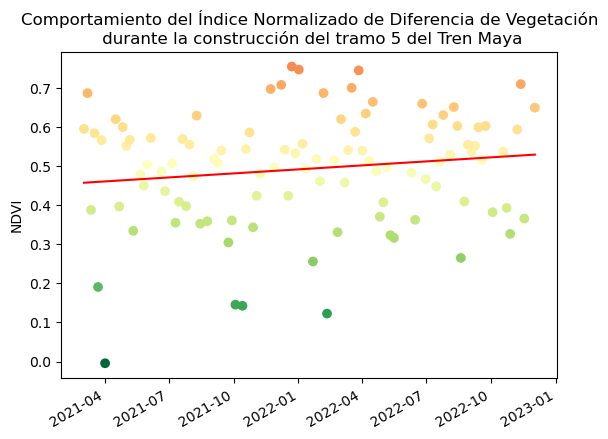

In [133]:
# Gráfico para analizar el comportamiento del NDVI

cmap = plt.cm.RdYlGn_r
norm = matplotlib.colors.Normalize(vmin = 0, vmax = 1)

fig, ax = plt.subplots()
ax.scatter(tramo5_ndvi_clean.date, tramo5_ndvi_clean.ndvi, color = cmap(norm(tramo5_ndvi_clean.ndvi)))
fig.autofmt_xdate()
x = np.array(dates.date2num(tramo5_ndvi_clean.date))
y = np.array(tramo5_ndvi_clean.ndvi)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)

plt.plot(x, p(x), color = "r")

ax.set_ylabel("NDVI")
ax.set_title("Comportamiento del Índice Normalizado de Diferencia de Vegetación\n durante la construcción del tramo 5 del Tren Maya")

## Conclusión

La construcción del tramo 5 del Tren Maya parece tener un impacto negativo en la vegetación de la zona, puesto que el análisis exploratorio muestra una reducción en el porcentaje de vegetación y un incremento en el índice normalizado de diferencia de vegetación durante el período de su construcción. Esto abre la puerta para un análisis a profundidad de este y los demás tramos construídos hasta el momento. Las imágenes de percepción remota representan una oportunidad de monitoreo constante, además de ofrecer información del pasado.